 **Загрузка данных из колаба**

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ltcmdrdata/plain-text-wikipedia-202011
!unzip /content/plain-text-wikipedia-202011.zip

100% 7.72G/7.72G [00:58<00:00, 208MB/s]
100% 7.72G/7.72G [00:58<00:00, 142MB/s]
Archive:  /content/plain-text-wikipedia-202011.zip
  inflating: enwiki20201020/00c2bfc7-57db-496e-9d5c-d62f8d8119e3.json  
  inflating: enwiki20201020/00e58afe-3ef5-42a6-92f3-8ee7abf868e1.json  
  inflating: enwiki20201020/0104b39c-7aa4-45cd-8d28-b05dc6bafdf2.json  
  inflating: enwiki20201020/01472aab-d8c2-43aa-b510-e259d58cd9a4.json  
  inflating: enwiki20201020/017a0674-613b-428d-8e3a-7dcf86b72edb.json  
  inflating: enwiki20201020/0203e66f-4fda-4f79-b454-ef353914810b.json  
  inflating: enwiki20201020/02343952-78b0-4e51-9d0f-ccfc6afd1eff.json  
  inflating: enwiki20201020/0266c1a8-c9e9-4fe5-b271-85269772e88e.json  
  inflating: enwiki20201020/034254a6-d1ba-4619-b7a8-4b3f2098f37f.json  
  inflating: enwiki20201020/034c6cd6-4e94-4be4-96a0-9e077b2ed089.json  
  inflating: enwiki20201020/03a621b9-c2e8-4a8a-a992-e6353ebd8ddc.json  
  inflating: enwiki20201020/03b5cca3-309c-4377-b481-cbd9909b2644.json  
  inf

Создание списка из статей википедии

In [ ]:
class Document:
    def __init__(self, title, text, id, stem):
        self.title = title
        self.text = text
        self.id = id
        self.stem_form = stem
    def format(self):
        return [self.title, self.text[:min(100, len(self.text) - 1)] + ' ...']

Решил ограничить датасет 150k элементами , примерно пол гигбайта(конкерентный файлы в гугл диске по ссылке в фале data.txt)

In [ ]:
import json
from os import listdir

big_list = []
id = 0
for title in listdir("/content/enwiki20201020"):
  with open(f"/content/enwiki20201020/{title}", "r") as read_file:
    data = json.load(read_file)
    for i in data:
      tmp = Document(i['title'], i['text'], id, '')
      big_list.append(tmp)
      id += 1
    print(title)
    if len(big_list) > 150000:
      break

e9d0f82a-83dd-4f4f-b99f-203e112eeac4.json
6864b8f2-be58-4354-89c6-b9214ca1803f.json
520a6f72-d000-4faf-9ac6-f6b89fbd63af.json
5cebd016-2686-4c6e-ac09-5468f570cf85.json
f94e8ddd-75bc-4324-b19c-2aaeaf8cfd93.json
792e2319-ad30-4837-a6a5-d4c9e1ac2398.json
a2518a43-f650-400e-a5bf-b4cc61458fda.json
511b2464-cfed-48fe-aa6c-403908cbbb05.json
0d624f1d-e9d1-4826-9e63-e39730ee7715.json
55d304b3-2f81-4987-ab91-823526e81ab5.json
39d74d8b-949e-4d64-8eb0-4e5744daa84e.json
5351f69a-bffc-471a-98f2-1f23e923fa57.json
d6737f43-6d55-4b81-add1-9e263f6a5f9c.json
c7d15d91-9546-43d4-a6af-7ea36aa5fb36.json


Обрабатываю текста в два потока, на 12 потоках это занимает 2 минуты

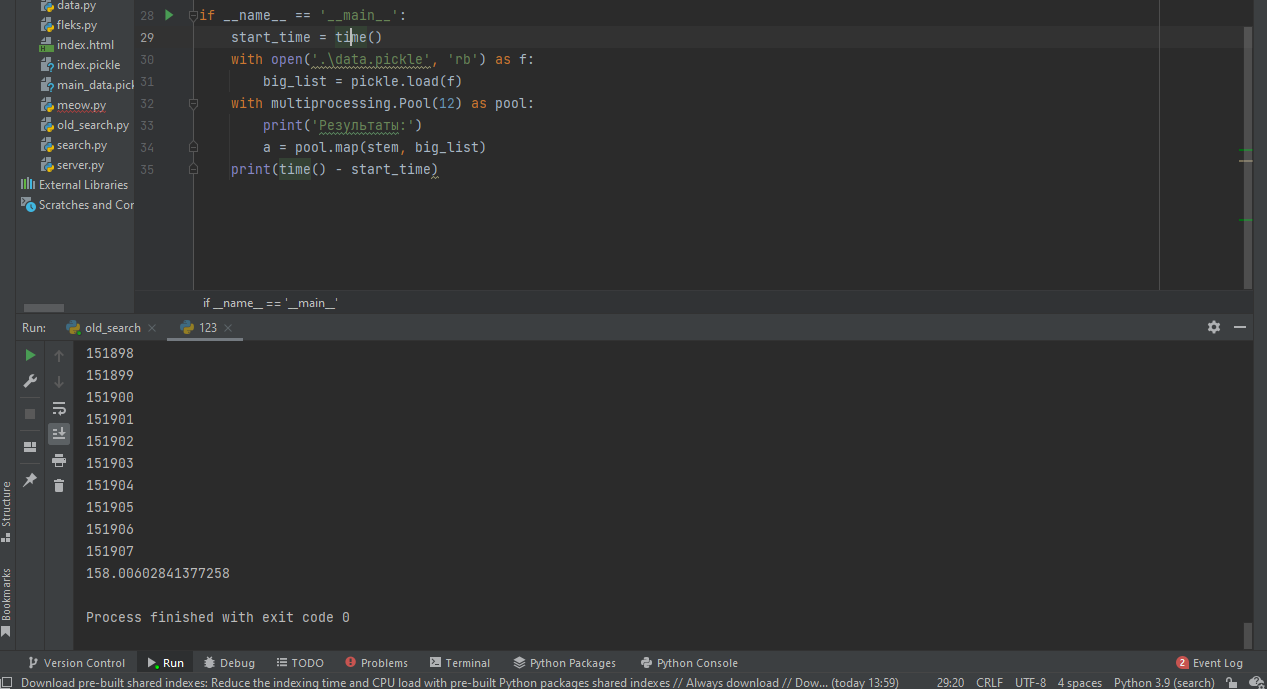

In [ ]:
import re
import tqdm
from nltk.stem.snowball import SnowballStemmer
import multiprocessing
stemmer = SnowballStemmer(language='english')
def stem(doc):
  print(doc.id)
  doc.stem_form = set(stemmer.stem(i) for i in re.sub(r'[^\w\s]','', doc.text).lower().split())
  return doc
if __name__ == '__main__':
    with multiprocessing.Pool(2) as pool:
        print('Результаты:')
        a = pool.map(stem, big_list)

In [ ]:
main_data = {}
for i in a:
  main_data[i.id] = i

In [ ]:
import pickle

with open('main_data.pickle', 'wb') as f:
  pickle.dump(main_data, f)

In [ ]:
!cp /content/main_data.pickle /content/drive/MyDrive

инвертированный индекс, он уже отсортирован, так как main_data была отсортировна

In [ ]:
import re
import tqdm
from nltk.stem.snowball import SnowballStemmer
ready_dict = {}
for i in main_data.values():
  for j in i.stem_form:
    if j not in ready_dict:
      ready_dict[j] = []
    ready_dict[j].append(i.id)

In [ ]:
with open('index.pickle', 'wb') as f:
  pickle.dump(ready_dict, f)

In [ ]:
!cp /content/index.pickle /content/drive/MyDrive